In [4]:
import time

start = time.time()

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
# %matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.figure_factory import create_trisurf
from plotly.graph_objs import *

from glob import glob

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize


In [6]:
source = "F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/For upload/3D-Reconstruction-of-CT-and-MRI/test"
folder_name = os.listdir(source)
print(source)
input = source + folder_name[0]

output = working = "/kaggle/working/"
if not os.path.exists(output):
    os.makedirs(os.getcwd() + output)
g = glob(input + '/*.dcm')

F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/For upload/3D-Reconstruction-of-CT-and-MRI/test


In [3]:
print ("Check DICOM images count %d .\n" % len(g))
print ('Check Filenames: \n'.join(g[:5]))

Check DICOM images count 62 .

F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/test/ID00421637202311550012437\1.dcmCheck Filenames: 
F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/test/ID00421637202311550012437\10.dcmCheck Filenames: 
F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/test/ID00421637202311550012437\11.dcmCheck Filenames: 
F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/test/ID00421637202311550012437\12.dcmCheck Filenames: 
F:/1_COLLEGE/TERM 11/Grad/MFG 718M/FIALS/test/ID00421637202311550012437\13.dcm


In [4]:
def load_CT(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = thickness
        
    return slices

In [5]:
def get_pixels_hu(scans):
    img = np.stack([s.pixel_array for s in scans])
    img = img.astype(np.int16)
    img[img == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        img = slope * img.astype(np.float64)
        img = img.astype(np.int16)
        
    img += np.int16(intercept)
    
    return np.array(img, dtype=np.int16)

In [6]:
id=2
patient = load_CT(input)
imgs = get_pixels_hu(patient)

In [7]:
np.save(output + "fullimages_%d.npy" % (id), imgs)

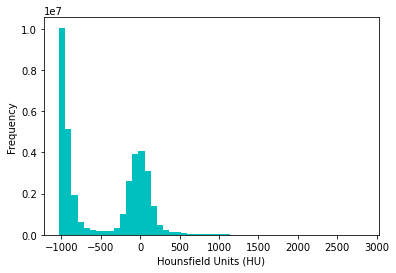

In [8]:
file_used=output+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

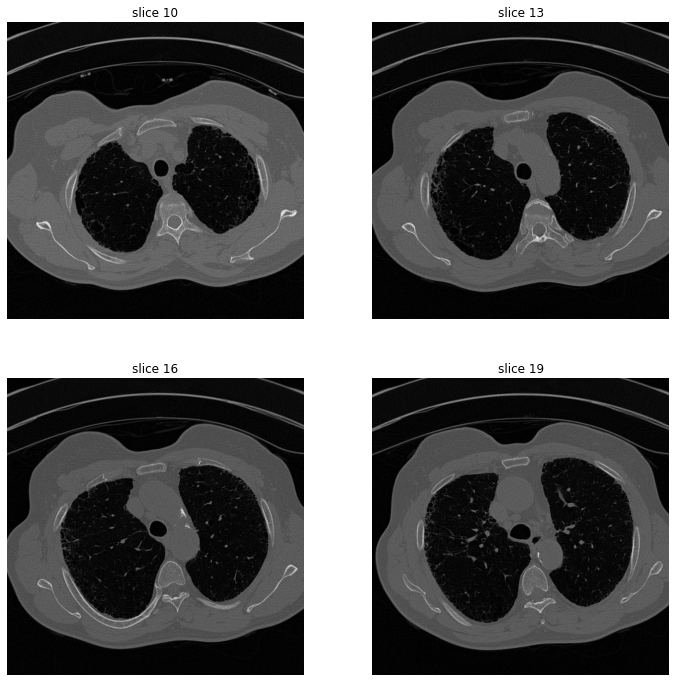

In [9]:
id = 2
imgs_to_process = np.load(output+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=2, cols=2, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [10]:
print ("Slice Thickness: %f" % patient[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 9.000000
Pixel Spacing (row, col): (0.415365, 0.415365) 


In [11]:
id = 2
imgs_to_process = np.load(output+'fullimages_{}.npy'.format(id))
print ("Shape before resampling\t", imgs_to_process.shape)

Shape before resampling	 (62, 768, 768)


In [12]:
def resample(img, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    #spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / img.shape
    new_spacing = spacing / real_resize_factor
    
    img = scipy.ndimage.interpolation.zoom(img, real_resize_factor)
    
    return img, new_spacing

In [13]:
new_img_resampled, spacing = resample(imgs_to_process, patient)
print ("Shape after resampling\t", new_img_resampled.shape)

C:\Users\JANMIC~1\AppData\Local\Temp/ipykernel_23352/2631594660.py:13: DeprecationWarning:

Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.



Shape after resampling	 (558, 319, 319)


In [14]:
def gen_mesh(img, threshold= -300, step_size=1): #threshold = -300

    print ("Transposing surface")
    p = img.transpose(2,1,0)
        
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)
    
    return verts, faces

In [15]:
def plotly_3d(vertices, faces):
    x,y,z = zip(*vertices) 
    
    # Make the colormap single color since the axes are positional not intensity. 
    #colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

In [16]:
def plt_3d(vertices, faces):
    x,y,z = zip(*vertices) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    print ("Drawing")
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(vertices[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

In [17]:
v, f = gen_mesh(new_img_resampled, 350)

Transposing surface
Calculating surface


In [18]:
v, f = gen_mesh(new_img_resampled, 350, 5) #350

Transposing surface
Calculating surface


In [19]:
plotly_3d(v, f)

Drawing


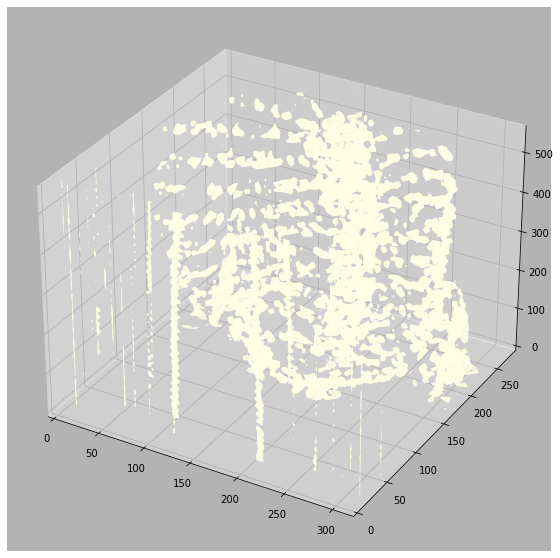

In [20]:
plt_3d(v, f)

In [21]:
end = time.time()

print(end - start)

33.99892830848694
